<a href="https://colab.research.google.com/github/MindPath-Learning-Systems/MindPath-Learning-Systems/blob/main/Predicting_Students'_Math_Scores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction & Setup

Short project description

Project framing:

We will build an AI solution that helps educational institutions identify students at risk of performing poorly and to forecast student exam performance. Using the StudentsPerformance dataset, the solution will provide (a) a classification model to predict whether a student will pass or fail (binary), and (b) a regression model to predict a student’s average exam score. These two outputs can be used by educators: classify and flag at-risk students for intervention, and forecast expected performance for resource planning.

Problem definition:

Many schools and learning institutions want early, actionable signals about student performance so they can target remedial support (tutoring, extra practice). The problem: given a student’s demographic and background features (gender, parental education, lunch type, test prep, etc.), predict whether they will pass and estimate their average score. Solving this with AI enables proactive interventions and resource allocation. The dataset (Kaggle StudentsPerformance) contains 1,000 anonymized records with exam scores and background features; this is suitable for supervised learning. Benefits include early detection of at-risk

In [2]:
# ========================
# 1. Setup
# ========================
!pip install xgboost shap seaborn joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import joblib


# Load Dataset

Import StudentsPerformance.csv (upload to Colab or load from Drive).

In [3]:
# ========================
# 2. Load dataset
# ========================
from google.colab import files

# Upload StudentsPerformance.csv
uploaded = files.upload()

df = pd.read_csv("StudentsPerformance.csv")
df.head()


Saving StudentsPerformance.csv to StudentsPerformance (1).csv


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


# Exploratory Data Analysis (EDA)

Distribution of math scores.

Boxplots by categories.

Correlation heatmap.

Shape: (1000, 8)
       math score  reading score  writing score
count  1000.00000    1000.000000    1000.000000
mean     66.08900      69.169000      68.054000
std      15.16308      14.600192      15.195657
min       0.00000      17.000000      10.000000
25%      57.00000      59.000000      57.750000
50%      66.00000      70.000000      69.000000
75%      77.00000      79.000000      79.000000
max     100.00000     100.000000     100.000000


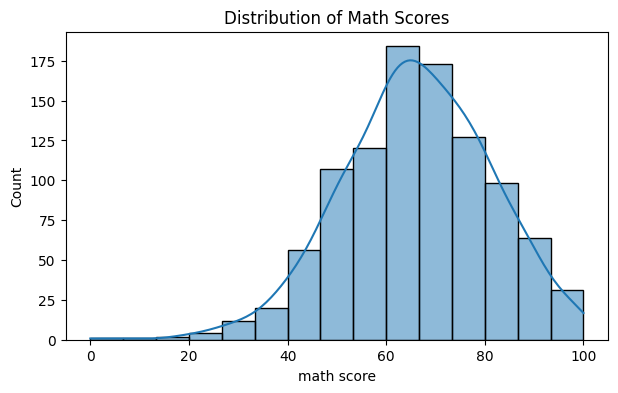

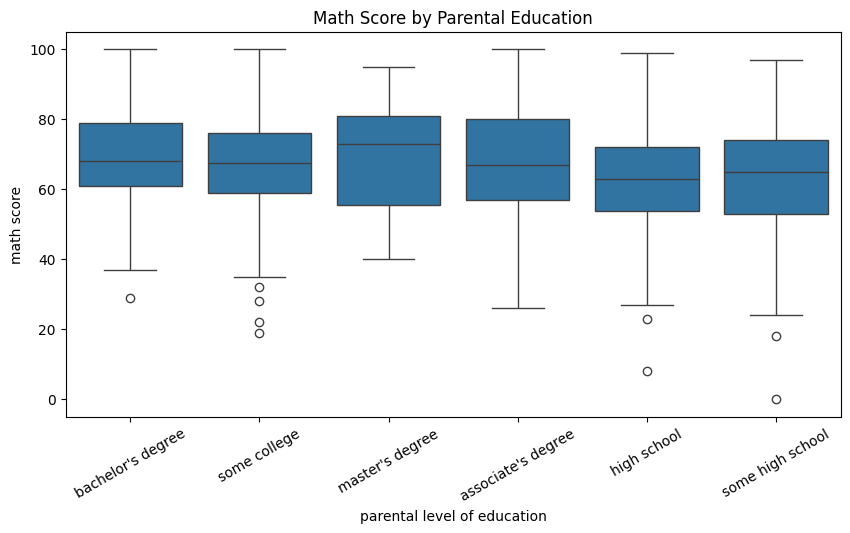

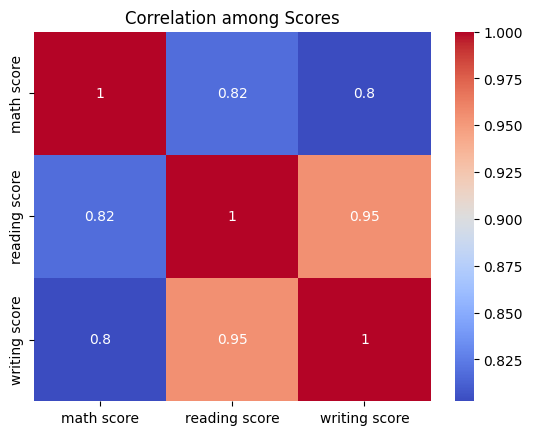

In [4]:
# ========================
# 3. EDA
# ========================
print("Shape:", df.shape)
print(df.describe())

# Distribution of math scores
plt.figure(figsize=(7,4))
sns.histplot(df['math score'], bins=15, kde=True)
plt.title("Distribution of Math Scores")
plt.show()

# Boxplot: math score by parental education
plt.figure(figsize=(10,5))
sns.boxplot(x='parental level of education', y='math score', data=df)
plt.xticks(rotation=30)
plt.title("Math Score by Parental Education")
plt.show()

# Correlation heatmap
corr = df[['math score','reading score','writing score']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation among Scores")
plt.show()


# Preprocessing

Feature engineering (avg_other, encoding categoricals).

Train/test split.

Scaling + one-hot encoding with pipeline.

In [11]:
# ========================
# 4. Preprocessing
# ========================
df['avg_other'] = df[['reading score','writing score']].mean(axis=1)
X = df.drop(columns=['math score'])
y = df['math score']

cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = ['reading score','writing score','avg_other']

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", StandardScaler(), num_cols)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Model Training

Linear Regression (baseline).

RandomForestRegressor (stronger).

Optional XGBoost.

In [12]:
# ========================
# 5. Train Models
# ========================

# Linear Regression
lin_pipe = Pipeline([("pre", preprocessor), ("model", LinearRegression())])
lin_pipe.fit(X_train, y_train)

# Random Forest
rf_pipe = Pipeline([("pre", preprocessor), ("model", RandomForestRegressor(n_estimators=200, random_state=42))])
rf_pipe.fit(X_train, y_train)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'race/ethnicity',
                                                   'parental level of '
                                                   'education',
                                                   'lunch',
                                                   'test preparation course']),
                                                 ('num', StandardScaler(),
                                                  ['reading score',
                                                   'writing score',
                                                   'avg_other'])])),
                ('model',
                 RandomForestRegressor(n_estimators=200, random_state=42))])

# Model Evaluation

Metrics: MAE, RMSE, R².

Residual plots.

Save results table.


=== Linear Regression ===
Linear Regression - MAE: 4.21, RMSE: 29.10, R²: 0.880

=== Random Forest ===
Random Forest - MAE: 4.71, RMSE: 37.12, R²: 0.847


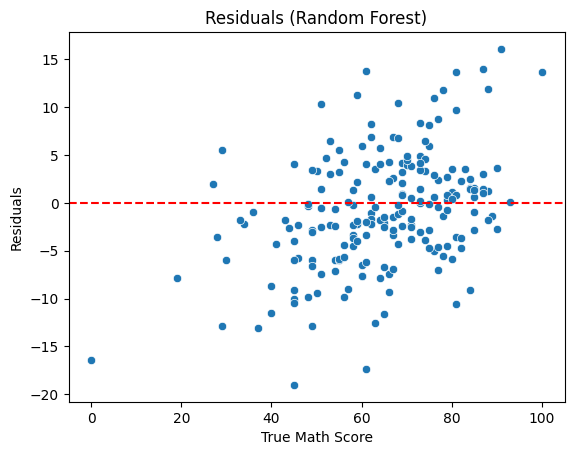

In [8]:
# ========================
# 6. Evaluate Models
# ========================
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred) # Removed squared=False
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.3f}")
    return y_pred

print("\n=== Linear Regression ===")
lin_preds = evaluate(lin_pipe, X_test, y_test, "Linear Regression")

print("\n=== Random Forest ===")
rf_preds = evaluate(rf_pipe, X_test, y_test, "Random Forest")

# Residuals plot for Random Forest
sns.scatterplot(x=y_test, y=y_test - rf_preds)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("True Math Score")
plt.ylabel("Residuals")
plt.title("Residuals (Random Forest)")
plt.show()

# Feature Importance / Explainability

Random Forest feature importances.

Optional SHAP summary plot.

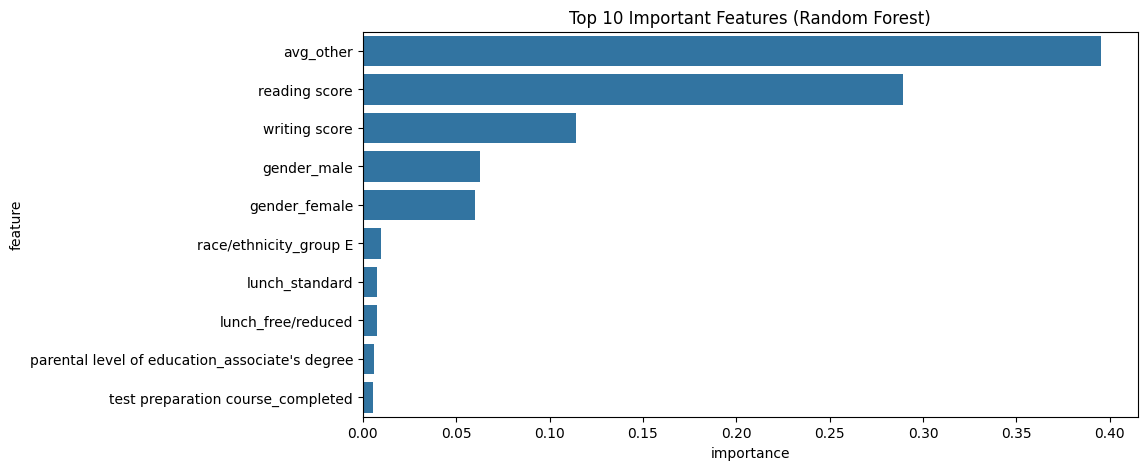

In [9]:
# ========================
# 7. Feature Importance (Random Forest)
# ========================
# Extract feature names from pipeline
encoder = rf_pipe.named_steps['pre'].transformers_[0][1]
encoded_features = encoder.get_feature_names_out(cat_cols)
all_features = list(encoded_features) + num_cols

importances = rf_pipe.named_steps['model'].feature_importances_
feat_imp = pd.DataFrame({"feature": all_features, "importance": importances})
feat_imp = feat_imp.sort_values("importance", ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x="importance", y="feature", data=feat_imp.head(10))
plt.title("Top 10 Important Features (Random Forest)")
plt.show()


# Save & Load Models

Save models to .joblib.

Demonstrate how to reload and predict on new data.

In [10]:
# ========================
# 8. Save Models
# ========================
joblib.dump(rf_pipe, "math_rf_model.joblib")
joblib.dump(lin_pipe, "math_lin_model.joblib")
print("Models saved!")

# Example: Load back and predict
loaded = joblib.load("math_rf_model.joblib")
sample = X_test.iloc[[0]]
print("Sample input:\n", sample)
print("Predicted math score:", loaded.predict(sample))


Models saved!
Sample input:
      gender race/ethnicity parental level of education     lunch  \
521  female        group C          associate's degree  standard   

    test preparation course  reading score  writing score  avg_other  
521                    none             86             84       85.0  
Predicted math score: [74.895]
